In [14]:
import numpy as np 
import pandas as pd 
import hiive.mdptoolbox, hiive.mdptoolbox.mdp, hiive.mdptoolbox.example
import mdptoolbox, mdptoolbox.example
import gym
import matplotlib.pyplot as plt


In [15]:
# code used here is received from 
# https://www.kaggle.com/code/benjaminschreiber/markov-decision-processes/notebook

In [23]:
# Generate a MDP example based on a simple forest management scenario.
P, R = hiive.mdptoolbox.example.forest(S=5000, p=0.01)
st = tm.time()
fm_q_mdp = hiive.mdptoolbox.mdp.QLearning(P, R, 0.99, epsilon=0.1,epsilon_decay=0.95, n_iter=10000, 
                                          alpha=0.90, skip_check=True)
fm_q_mdp.run()
ed = tm.time()


In [24]:
def make_time_array(run_stats, variables):
    cumulative_sum = 0
    times = []
    output_dict = {v:[] for v in variables}
    output_dict["times"] = times
    for result in run_stats:
        times.append(result["Time"])
        for v in result:
            if v in variables:
                output_dict[v].append(result[v])
    return output_dict

def plot_simple_data(x_var, y_var, x_label, y_label, title, figure_size=(6,4)):
    plt.rcParams["figure.figsize"] = figure_size
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_var, y_var)
    plt.grid()
    plt.show()


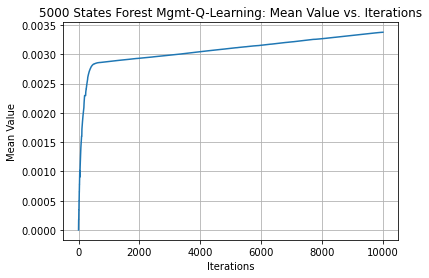

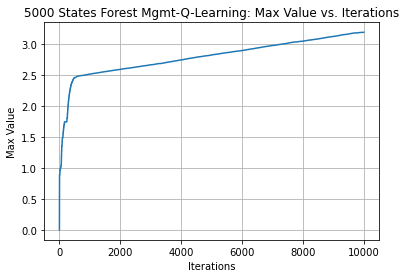

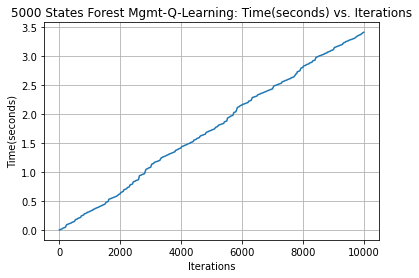

In [29]:
fm_q_curated_results = make_time_array(fm_q_mdp.run_stats, ["Mean V", "Max V", "Iteration"])
num_iters = len(fm_q_curated_results["Mean V"])
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["Mean V"], 
                 "Iterations", "Mean Value", "5000 States Forest Mgmt-Q-Learning: Mean Value vs. Iterations")
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["Max V"], 
                 "Iterations", "Max Value", "5000 States Forest Mgmt-Q-Learning: Max Value vs. Iterations")
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["times"], 
                 "Iterations", "Time(seconds)", "5000 States Forest Mgmt-Q-Learning: Time(seconds) vs. Iterations")



In [26]:
def run_forest(solver, states, discounts, epsilons, probability=0.1, max_iter=1000):
    experiments = [] #num states, probability, discount, time, iterations, policy
    for s in states:
        for e in epsilons:
            for d in discounts:
                entry = {}
                P, R = hiive.mdptoolbox.example.forest(S=s, p=probability)
                #start_time = time.time()
                args = {"transitions":P, "reward":R, "gamma":d, "epsilon":e, "max_iter":max_iter, "skip_check":True}
                mdp = solver(args)
                mdp.run()
                #end_time = time.time()
                entry["time"] = mdp.time
                entry["iterations"] = mdp.iter
                entry["policy"] = mdp.policy
                entry["num_states"] = s
                entry["probability"] = probability
                entry["discount"] = d
                entry["epsilon"] = e
                entry["run_stats"] = mdp.run_stats
                experiments.append(entry)
    return experiments

def compose_discounts(significant_digits):
    prev_discount = 0
    discounts = []
    for i in range(1,significant_digits + 1):
        discounts.append(round(prev_discount + 9*(10**-i),i))
        prev_discount = discounts[-1]
    return discounts

def collect_training_results(results, keys, to_print=True):
    output_dict = {key:[] for key in keys}
    for result in results:
        if to_print: print("\nNew result #################")
        for key in result:
            if key in keys:
                if to_print: print("{0}: {1}".format(key,result[key]))
                output_dict[key].append(result[key])
    return output_dict


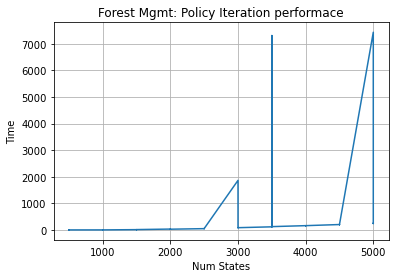

In [27]:
states = [500*s for s in range(1,11)]
discounts = compose_discounts(3)
discounts = [0.999999,0.9999]
epsilons = [0.01, 0.005, 0.001]

fm_policy_iteration = lambda dict_args: hiive.mdptoolbox.mdp.PolicyIterationModified(**dict_args)
fm_policy_iteration_results = run_forest(fm_policy_iteration, states, discounts, epsilons)

fm_policy_iteration = lambda dict_args: hiive.mdptoolbox.mdp.PolicyIterationModified(**dict_args)
fm_policy_iteration_results = run_forest(fm_policy_iteration, states, discounts, epsilons)
fm_pi_time_num_states = collect_training_results(fm_policy_iteration_results, ["time", "num_states"], 
                                                 to_print=False)
fm_pi_iters_num_states = collect_training_results(fm_policy_iteration_results, 
                                                  ["iterations", "num_states"], to_print=False)
plot_simple_data(fm_pi_time_num_states["num_states"], 
                 fm_pi_time_num_states["time"], "Num States", "Time", "Forest Mgmt: Policy Iteration performace")

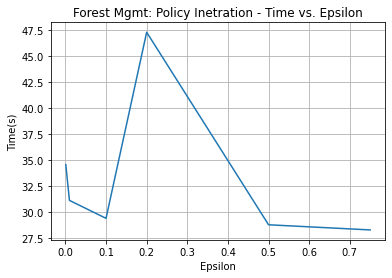

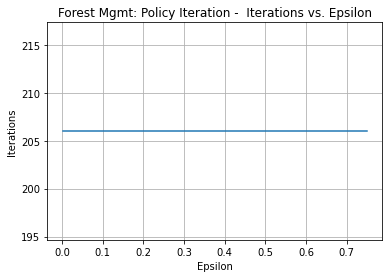

In [31]:
states = [5000]
discounts = [0.99]
epsilons = [0.001, 0.01, 0.1, 0.2,0.5,0.75]
fm_policy_iteration = lambda dict_args: hiive.mdptoolbox.mdp.PolicyIterationModified(**dict_args)
fm_policy_iteration_results = run_forest(fm_policy_iteration, states, discounts, epsilons, probability=0.0001, 
                                         max_iter=1000)
fm_pi_time_num_states = collect_training_results(fm_policy_iteration_results, ["time", "epsilon"], 
                                                 to_print=False)
fm_pi_iters_num_states = collect_training_results(fm_policy_iteration_results, ["iterations", "epsilon"], 
                                                  to_print=False)
plot_simple_data(fm_pi_time_num_states["epsilon"], fm_pi_time_num_states["time"], "Epsilon", "Time(s)", 
                 "Forest Mgmt: Policy Inetration - Time vs. Epsilon")
plot_simple_data(fm_pi_iters_num_states["epsilon"], fm_pi_iters_num_states["iterations"], "Epsilon",
                 "Iterations", "Forest Mgmt: Policy Iteration -  Iterations vs. Epsilon")

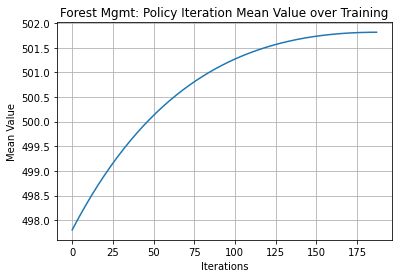

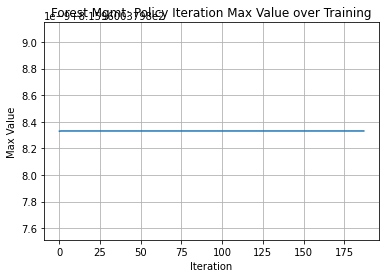

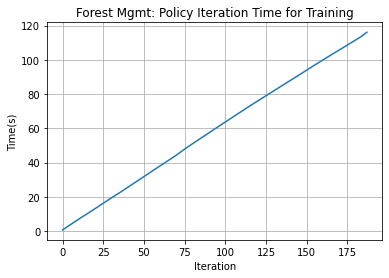

In [32]:
P_pi_fm, R_pi_fm = hiive.mdptoolbox.example.forest(S=5000, p=0.01)
dict_args = {"transitions":P_pi_fm, "reward":R_pi_fm, "gamma":0.9999, "epsilon":0.1, "max_iter":1000}
fm_pi_mdp = hiive.mdptoolbox.mdp.PolicyIteration(P_pi_fm, R_pi_fm, 0.999, max_iter = 5*10**2, skip_check=True)
fm_pi_mdp.run()
fm_pi_mdp_curated_results = make_time_array(fm_pi_mdp.run_stats, ["Mean V", "Max V"])
num_iters = len(fm_pi_mdp_curated_results["Mean V"])
plot_simple_data([i for i in range(num_iters)], fm_pi_mdp_curated_results["Mean V"], 
                 "Iterations", "Mean Value", "Forest Mgmt: Policy Iteration Mean Value over Training")
plot_simple_data([i for i in range(num_iters)], fm_pi_mdp_curated_results["Max V"], 
                 "Iteration", "Max Value", "Forest Mgmt: Policy Iteration Max Value over Training")
plot_simple_data([i for i in range(num_iters)], fm_pi_mdp_curated_results["times"], 
                 "Iteration", "Time(s)", "Forest Mgmt: Policy Iteration Time for Training")

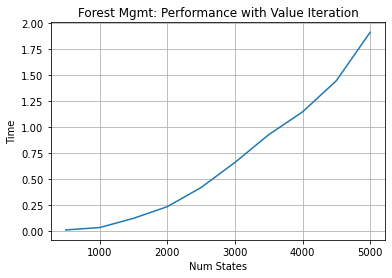

In [33]:
states = [500*s for s in range(1,11)]
discounts = [0.999]
epsilons = [0.1]
fm_value_iteration = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
fm_value_iteration_results = run_forest(fm_value_iteration, states, discounts, epsilons)  
fm_vi_time_num_states = collect_training_results(fm_value_iteration_results, ["time", "num_states"], to_print=False)
fm_vi_iters_num_states = collect_training_results(fm_value_iteration_results, ["iterations", "num_states"], 
                                                  to_print=False)
plot_simple_data(fm_vi_time_num_states["num_states"], fm_vi_time_num_states["time"], "Num States", "Time",
                 "Forest Mgmt: Performance with Value Iteration")

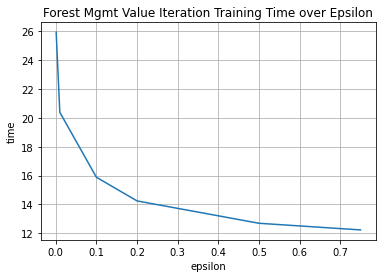

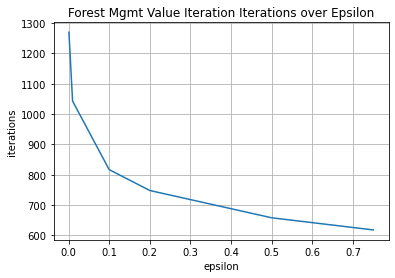

In [36]:
states = [5000]
discounts = [0.99]
epsilons = [0.001, 0.01, 0.1, 0.2,0.5,0.75]
fm_value_iteration = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
fm_value_iteration_results = run_forest(fm_value_iteration, states, discounts, epsilons, probability=0.0001, 
                                        max_iter=10**2)  
fm_vi_time_num_states = collect_training_results(fm_value_iteration_results, ["time", "epsilon", "iterations"], to_print=False)
plot_simple_data(fm_vi_time_num_states["epsilon"], fm_vi_time_num_states["time"], "epsilon", "time", 
                 "Forest Mgmt Value Iteration Training Time over Epsilon")
plot_simple_data(fm_vi_time_num_states["epsilon"], fm_vi_time_num_states["iterations"], "epsilon", 
                 "iterations", "Forest Mgmt Value Iteration Iterations over Epsilon")


P: 
array([[0.01, 0.99, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.99, ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.01, 0.  , 0.  , ..., 0.  , 0.99, 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.99],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.99]])
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

R: 
array([0., 0., 0., ..., 0., 0., 4.])
array([0., 1., 1., ..., 1., 1., 2.])



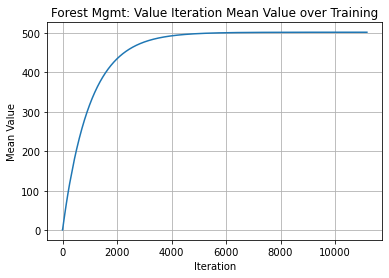

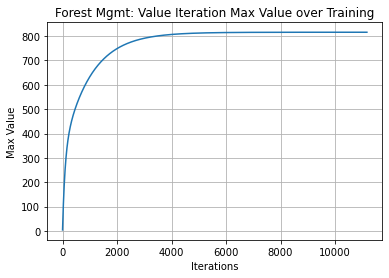

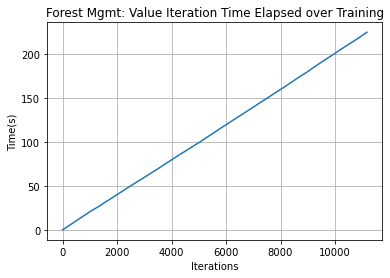

In [37]:
P_pi_fm, R_pi_fm = hiive.mdptoolbox.example.forest(S=5000, p=0.01)
dict_args = {"transitions":P_pi_fm, "reward":R_pi_fm, "gamma":0.999,"epsilon":10**(-50), 
             "max_iter":10**5, "skip_check":True}
fm_vi_mdp = hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
fm_vi_mdp.run()
print(fm_vi_mdp)
fm_vi_mdp_curated_results = make_time_array(fm_vi_mdp.run_stats, ["Mean V", "Max V"])
num_iters = len(fm_vi_mdp_curated_results["Mean V"])
plot_simple_data([i for i in range(num_iters)], fm_vi_mdp_curated_results["Mean V"], 
                 "Iteration", "Mean Value", "Forest Mgmt: Value Iteration Mean Value over Training")
plot_simple_data([i for i in range(num_iters)], fm_vi_mdp_curated_results["Max V"], 
                 "Iterations", "Max Value", "Forest Mgmt: Value Iteration Max Value over Training")
plot_simple_data([i for i in range(num_iters)], fm_vi_mdp_curated_results["times"], 
                 "Iterations", "Time(s)", "Forest Mgmt: Value Iteration Time Elapsed over Training")